## Example for a CNN-LSTM model to predict BTC close price over next 15 min

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [5]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [6]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [7]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [8]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [9]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (168354, 8)


In [10]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:01:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:16:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:31:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:46:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:01:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1654957800,1654957800,28622.76,28660.01,28495.00,28519.90,784.395750,13890.0,2022-06-11 14:31:00,2022-06-11 14:45:00
1654958700,1654958700,28519.89,28632.94,28386.70,28429.65,1466.600980,22926.0,2022-06-11 14:46:00,2022-06-11 15:00:00
1654959600,1654959600,28429.65,28605.15,28337.58,28540.25,1291.736230,20993.0,2022-06-11 15:01:00,2022-06-11 15:15:00


### Plot wick Candles and build features from technical analysis

In [11]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:01:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:16:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:31:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:46:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:01:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-06-11 14:31:00,28495.00,28660.01,28622.76,28519.90,784.395750
2022-06-11 14:46:00,28386.70,28632.94,28519.89,28429.65,1466.600980
2022-06-11 15:01:00,28337.58,28605.15,28429.65,28540.25,1291.736230


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

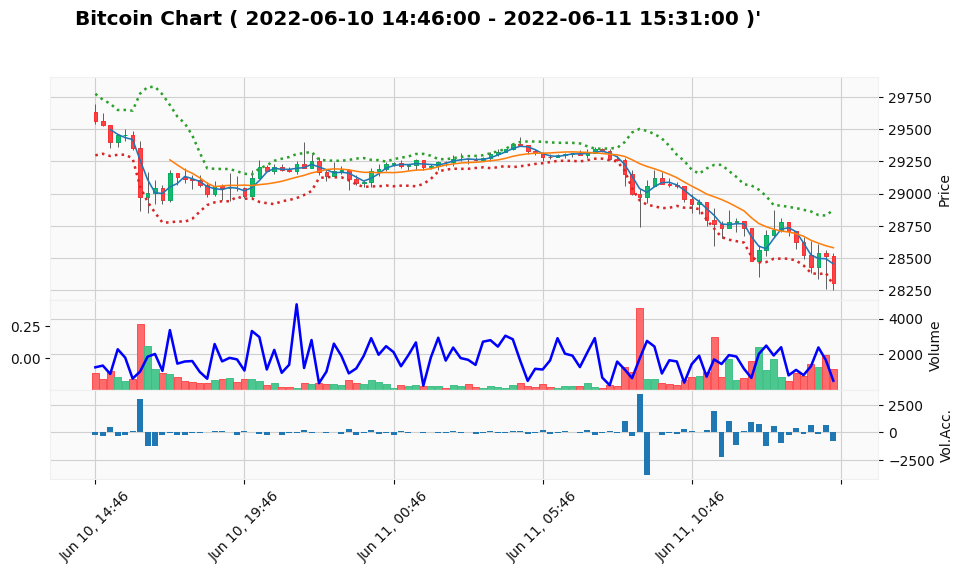

In [12]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

# Generate normalized timeseries

In [13]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [14]:
ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

[0.43541351980078585,
 0.43577334371286935,
 0.4363630652408463,
 0.43572080869331664,
 0.434930416137447,
 0.4339938906415738,
 0.43317217738080616,
 0.43417917446269977,
 0.4339300656004881,
 0.4320816887687049]

## Train a CNN-LSTM model 

In [15]:
btc_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.9)

In [16]:
btc_model.sats2model()
btc_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       896         ['Candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2048        ['Candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       3776        ['Candles[0][0]']                
                                                                                              

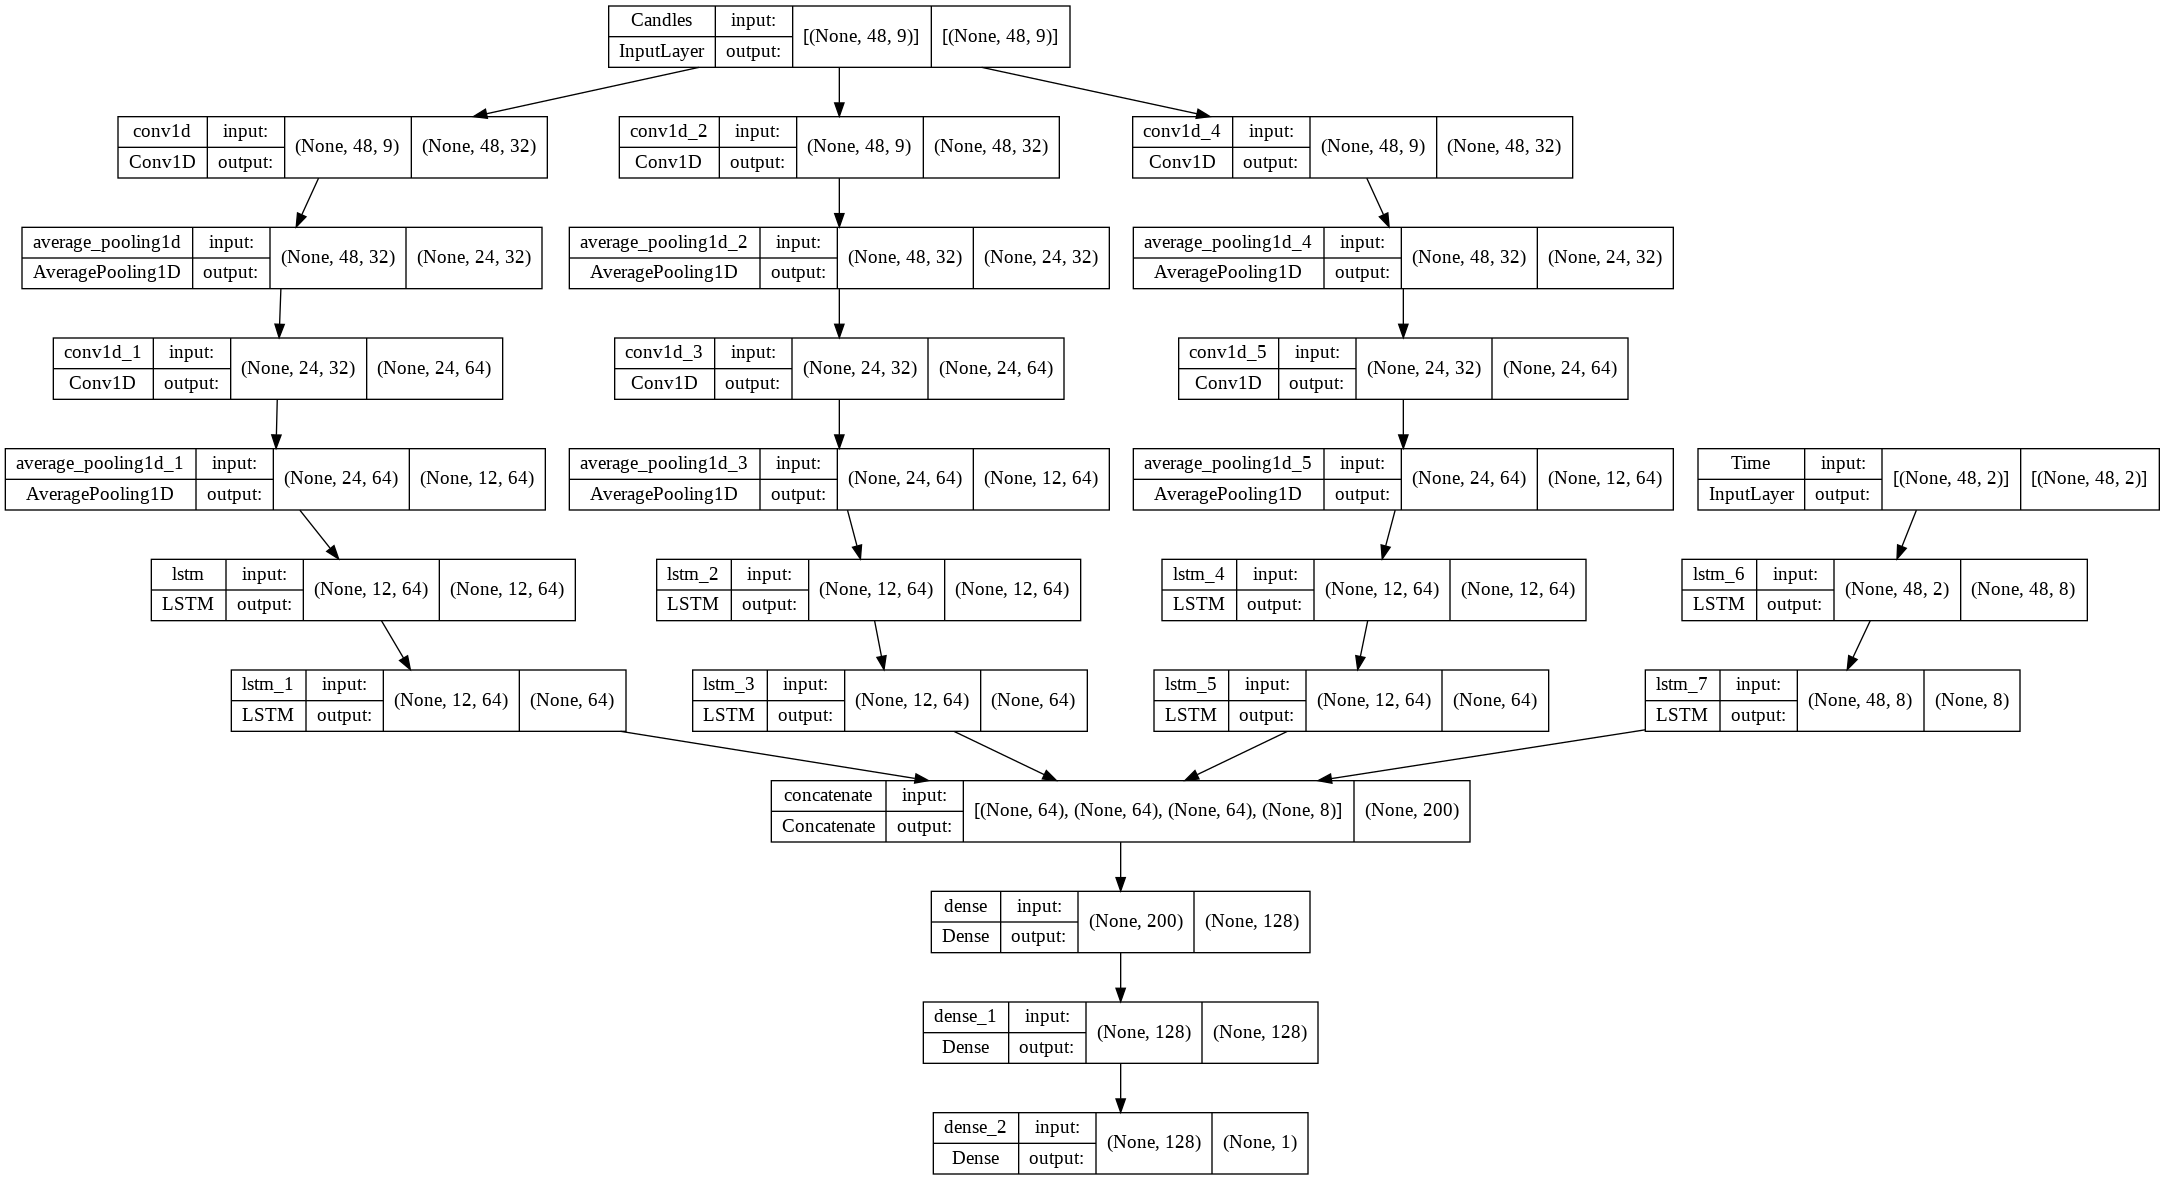

In [17]:
keras.utils.plot_model(btc_model.model, "conv_lstm_net.png", show_shapes=True)

In [18]:
btc_model.sats2train()

Epoch 1/20
11/11 [==============================] - 18s 434ms/step - loss: 0.2044 - val_loss: 0.1271
Epoch 2/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0549 - val_loss: 0.0530
Epoch 3/20
11/11 [==============================] - 1s 106ms/step - loss: 0.0368 - val_loss: 0.0564
Epoch 4/20
11/11 [==============================] - 1s 104ms/step - loss: 0.0209 - val_loss: 0.0522
Epoch 5/20
11/11 [==============================] - 1s 94ms/step - loss: 0.0312 - val_loss: 0.0211
Epoch 6/20
11/11 [==============================] - 1s 104ms/step - loss: 0.0193 - val_loss: 0.0124
Epoch 7/20
11/11 [==============================] - 1s 106ms/step - loss: 0.0177 - val_loss: 0.0294
Epoch 8/20
11/11 [==============================] - 1s 104ms/step - loss: 0.0161 - val_loss: 0.0063
Epoch 9/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0095 - val_loss: 0.0129
Epoch 10/20
11/11 [==============================] - 1s 106ms/step - loss: 0.0087 - val_loss: 0.0044

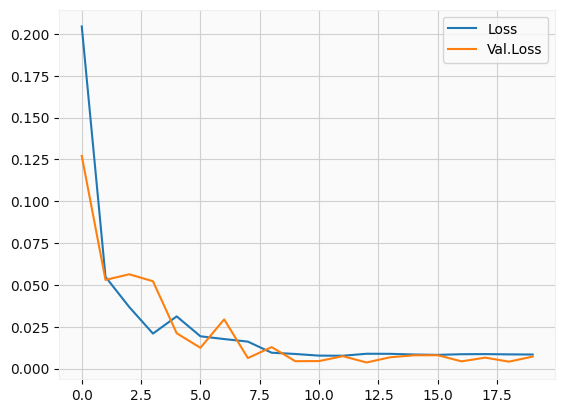

In [19]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [20]:
btc_model.sats2pred()

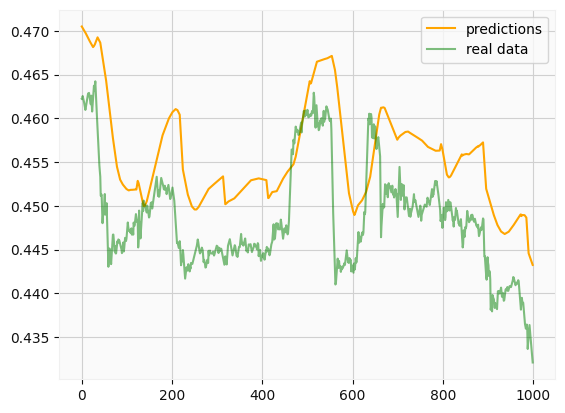

In [21]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [22]:
true_vals = ts_btc.denorm(ts_btc.candles_norm[:,-1])
preds = ts_btc.denorm(btc_model.preds)

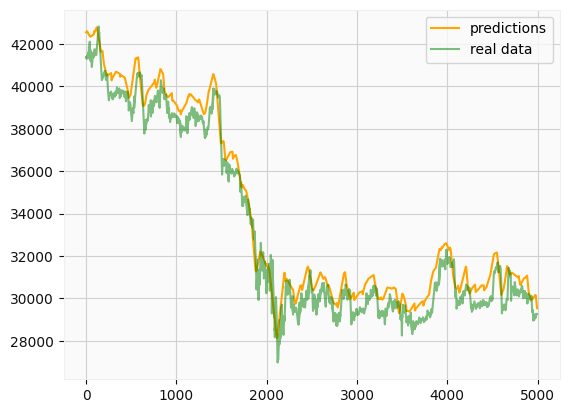

In [23]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

## Rough back-testing buy or do nothing, i.e. up-only

Fee: 0.025
----------------------
Buy      2025 ( 1198 ok 827 ko )
No-op    2971
Wallet   41335.141250000044
Drawback -843.2675000000008
Total earned 41335.141250000044


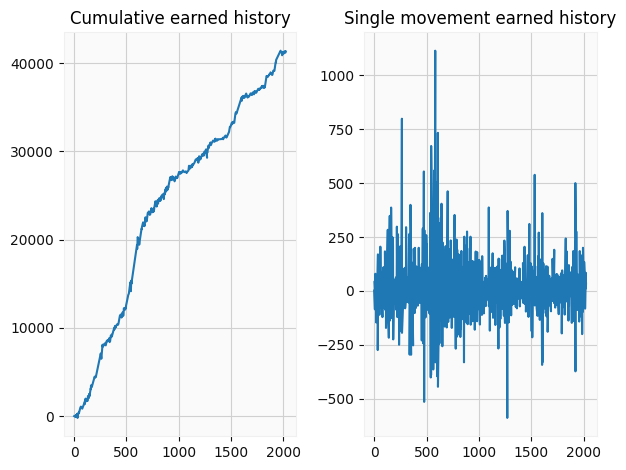

In [25]:
true_vals = ts_btc.denorm(ts_btc.candles_norm[:,-1])
preds = ts_btc.denorm(btc_model.preds)

total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)

print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

## Train for more epochs

In [26]:
preds_old = btc_model.preds
y_test_old = btc_model.y_test

In [27]:
btc_model.sats2train(epochs = 100)

Epoch 1/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 2/100
11/11 [==============================] - 1s 103ms/step - loss: 0.0087 - val_loss: 0.0059
Epoch 3/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0086 - val_loss: 0.0109
Epoch 4/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0090 - val_loss: 0.0060
Epoch 5/100
11/11 [==============================] - 1s 105ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 6/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0085 - val_loss: 0.0055
Epoch 7/100
11/11 [==============================] - 1s 107ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 8/100
11/11 [==============================] - 1s 106ms/step - loss: 0.0083 - val_loss: 0.0053
Epoch 9/100
11/11 [==============================] - 1s 94ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 10/100
11/11 [==============================] - 1s 103ms/step - loss: 0.0077 - val_los

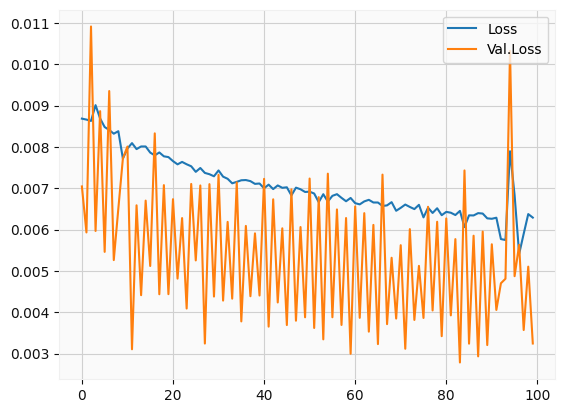

In [28]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [29]:
btc_model.sats2pred()

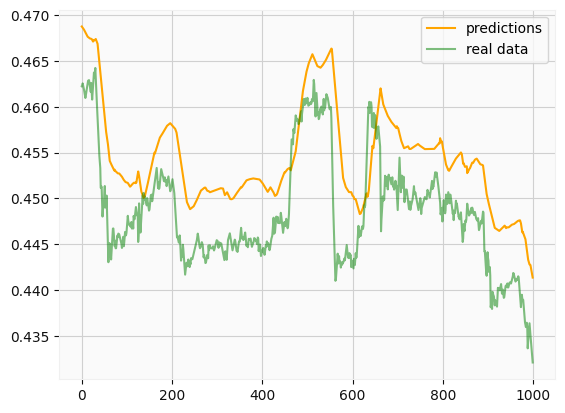

In [30]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

Fee: 0.025
----------------------
Buy      1314 ( 774 ok 540 ko )
No-op    3682
Wallet   26763.342249999878
Drawback -1132.0202499999998
Total earned 26763.342249999878


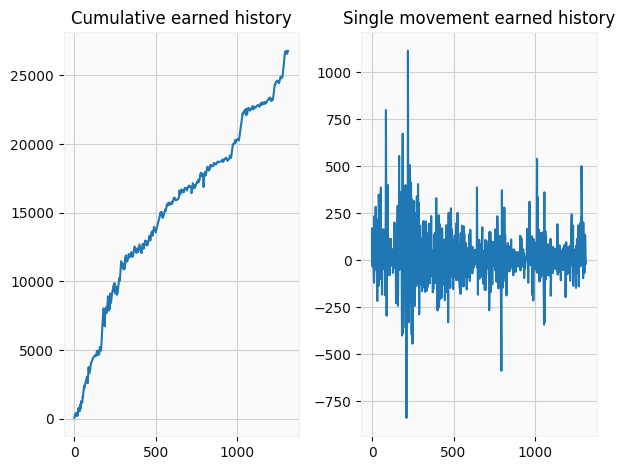

In [31]:
true_vals = ts_btc.denorm(ts_btc.candles_norm[:,-1])
preds = ts_btc.denorm(btc_model.preds)

total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

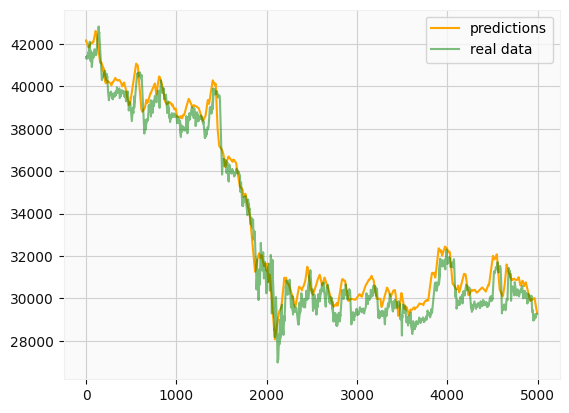

In [34]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [32]:
import src.timemethods as tm

df_pred_exp = pd.DataFrame(np.array([preds,true_vals[-len(preds):]]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = tm.log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = tm.log_return(df_pred_exp["Predicted"],periods=-1)


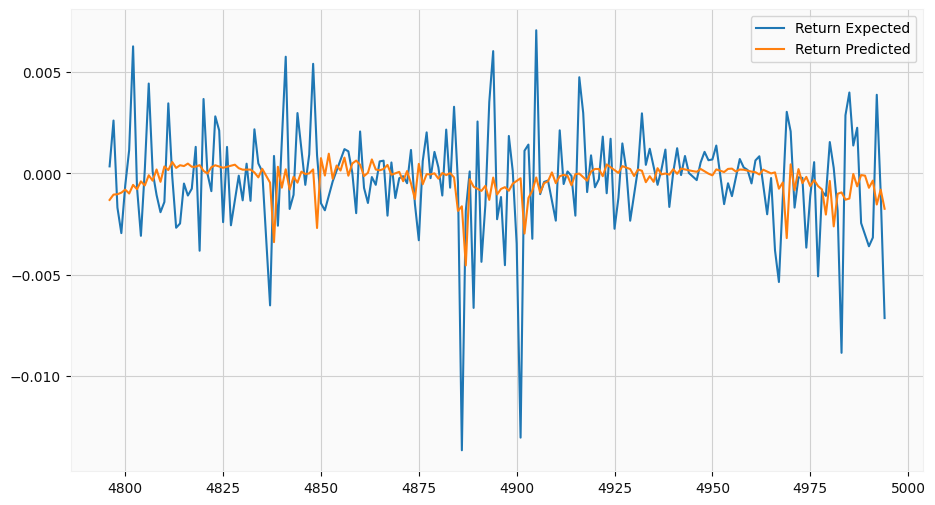

In [33]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-200:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-200:].plot(y="Return Predicted",ax=axs)